# Calibración de factores de minoración LRFD para fundaciones superficiales

### P. M. Fernández, A.O. Sfriso, J. Manduca, M. Biedma, P. M. Barbieri
#### Facultad de Ingeniería de la Universidad de Buenos Aires (2021)

## Librerias

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image
from scipy import stats
from scipy.stats import kstest
from scipy.stats import norm
from scipy.stats import lognorm
from scipy.stats import beta
#import seaborn as sns

#Shapes: 1 (Rectangular) | 2 (Circular) | 3 (Strip)
#Methods: 1 (Vesic 1975) | 2 (Hansen 1970) | 3 (Eurocode 7 2004) | 4 (Meyerhof 1963)

## Constantes

In [12]:
#LANGUAGE = 'EN'
LANGUAGE = 'ES'

## Función de capacidad de carga

### Funciones de capacidad de carga

In [13]:
def Nq(phi):
    phi = np.radians(phi)
    Nq = (np.exp(np.pi * np.tan(phi))) * ((np.tan(0.25 * np.pi + 0.5 * phi)) ** 2)
    return (Nq)

def Nc(phi):
    if phi == 0:
        Nc = (2 + np.pi)
    else:
        Nc = (Nq(phi) - 1) * (1 / np.tan(np.radians(phi)))
    return(Nc)

def Ng(phi, method):
    method = method.lower()
    if method == 'vesic':
        Ng = 2 * (Nq(phi) + 1) * np.tan(np.radians(phi)) #Vesic (1975)
    elif method == 'hansen':
        Ng = 1.5 * (Nq(phi) - 1) * np.tan(np.radians(phi)) #Hansen (1970)
    elif method == 'eurocode 7':
        Ng = 2 * (Nq(phi) - 1) * np.tan(np.radians(phi)) #Eurocode 7 (CEN 2004)
    elif method == 'meyerhof':
        Ng = (Nq(phi) - 1) * np.tan(1.4 * np.radians(phi)) #Meyerhof (1963)
    else:
        if LANGUAGE == 'EN':
            errormsg = "Unsuported Ng calculation method '{}'. ""Suported methods are: 'Vesic', 'Hansen', 'Eurocode 7' and 'Meyerhof'"
        elif LANGUAGE == 'ES':
            errormsg = "Metodo de calculo de Ng '{}' no disponible. Los metodos disponibles son: 'Vesic', 'Hansen', 'Eurocode 7' y 'Meyerhof'"
        raise RuntimeError(errormsg.format(method))
    return(Ng)

### Factores de forma

In [14]:
def c_cs(shape, phi, B=np.nan, L=np.nan):
    shape = shape.lower()
    if shape in ['rectangle', 'rectangulo']:
        if np.isnan(B) or np.isnan(L):
            if LANGUAGE == 'EN':
                errormsg = "B or L values not provided for a rectangular base. Provide this values as key word arguments."
            elif LANGUAGE == 'ES':
                errormsg = "El valor de B o L no fue provisto para la base rectangular."
                raise RuntimeError(errormsg)
        c_cs = 1 + (B/L) * (Nq(phi) / Nc(phi))
    elif shape in ['square', 'cuadrado', 'cuadrada']:
        c_cs = 1 + (1) * (Nq(phi) / Nc(phi))
    elif shape in ['circular', 'circle', 'circulo', 'circular']:
        c_cs = 1 + (0) * (Nq(phi) / Nc(phi))
    else:
        if LANGUAGE == 'EN':
            errormsg = "Unsuported base shape {}. ""Suported shapes are: 'rectangle', 'square' and 'circle'"
        elif LANGUAGE == 'ES':
            errormsg = "Forma de base {} no disponible. Las formas disponibles son: 'rectangulo', 'cuadrado' y 'circulo'"
        raise RuntimeError(errormsg.format(shape))
    return(c_cs)

def c_qs(shape, phi, B=np.nan, L=np.nan):
    shape = shape.lower()
    if shape in ['rectangle', 'rectangulo']:
        c_qs = 1 + (B/L) * np.tan(np.radians(phi))
    elif shape in ['square', 'cuadrado', 'cuadrada']:
        c_qs = 1 + (1) * np.tan(np.radians(phi))
    elif shape in ['circular', 'circle', 'circulo', 'circular']:
        c_qs = 1 + (0) * np.tan(np.radians(phi))
    else:
        if LANGUAGE == 'EN':
            errormsg = "Unsuported base shape {}. ""Suported shapes are: 'rectangle', 'square' and 'circle'"
        elif LANGUAGE == 'ES':
            errormsg = "Forma de base {} no disponible. Las formas disponibles son: 'rectangulo', 'cuadrado' y 'circulo'"
        raise RuntimeError(errormsg.format(shape))  
    return(c_qs)

def c_gs(shape, B=np.nan, L=np.nan):
    shape = shape.lower()
    if shape in ['rectangle', 'rectangulo']:
        c_gs = 1 - 0.4 * (B/L)
    elif shape in ['square', 'cuadrado', 'cuadrada']:
        c_gs = 1 - 0.4 * (1)
    elif shape in ['circular', 'circle', 'circulo', 'circular']:
        c_gs = 1 - 0.4 * (0)
    else:
        if LANGUAGE == 'EN':
            errormsg = "Unsuported base shape '{}'. ""Suported shapes are: 'rectangle', 'square' and 'circle'"
        elif LANGUAGE == 'ES':
            errormsg = "Forma de base '{}' no disponible. Las formas disponibles son: 'rectangulo', 'cuadrado' y 'circulo'"
        raise RuntimeError(errormsg.format(shape))  
    return(c_gs)

### Factores de profundidad

In [15]:
def c_qd(D, B, phi):
    c_qd = 1 + 2 * np.tan(np.radians(phi)) * ((1 - np.sin(np.radians(phi))) ** 2) * np.arctan(D/B)
    return(c_qd)

def c_gd(phi):
    c_gd = 1
    return(c_gd)

def c_cd(D, B, phi):
    if phi > 0:
        c_cd = c_qd(D, B, phi) - ((1 - c_qd(D, B, phi)) / (Nc(phi) * np.tan(np.radians(phi))))
    else:
        c_cd = 1 + 0.33 * np.arctan(D/B)
    return(c_cd)

### Capacidad de carga

In [16]:
def Bearing_Capacity(gamma_Ng, gamma_Nq, phi, c, B, L, D, q, shape, method):
    
    qu_c = c * Nc(phi) * c_cs(shape, phi, B=B, L=L) * c_cd(D, B, phi)
    qu_p = (q + D * gamma_Nq) * Nq(phi) * c_qs(shape, phi, B=B, L=L) * c_qd(D, B, phi)

    if shape == ['rectangle', 'rectangulo']:
        qu_g_B = 0.5 * gamma_Ng * B * Ng(phi, method) * c_gs(shape, B=B, L=L) * c_gd(phi)
        qu_g_L = 0.5 * gamma_Ng * L * Ng(phi, method) * c_gs(shape, B=B, L=L) * c_gd(phi)
        qu = np.minimum(qu_c + qu_p + qu_g_B , qu_c + qu_p + qu_g_L)
    else:
        qu = qu_c + qu_p + 0.5 * gamma_Ng * B * Ng(phi, method) * c_gs(shape, B=B, L=L) * c_gd(phi)

    return(qu)

In [17]:
def gamma_q(D, NF, gs):
    if NF <= D:
        gamma = (gs * NF + (gs - 10) * (D - NF)) / D
    else:
        gamma = gs
    return gamma

In [18]:
def gamma_g(B, D, NF, gs):
    if NF <= D:
        gamma = gs - 10
    elif NF > D and NF <= D + 3 * B:
        gamma = (gs * (NF - D) + (gs - 10) * (3 * B - NF)) / (3 * B - D)
    else:
        gamma = gs
    return gamma

## Base de datos

In [19]:
#Importar base de datos
df = pd.read_table('xxxx.txt')
df["Shape"].replace({1: "rectangle", 2: "square", 3:'circle'}, inplace=True)
df.head()

FileNotFoundError: [Errno 2] No such file or directory: 'xxxx.txt'

NameError: name 'df' is not defined

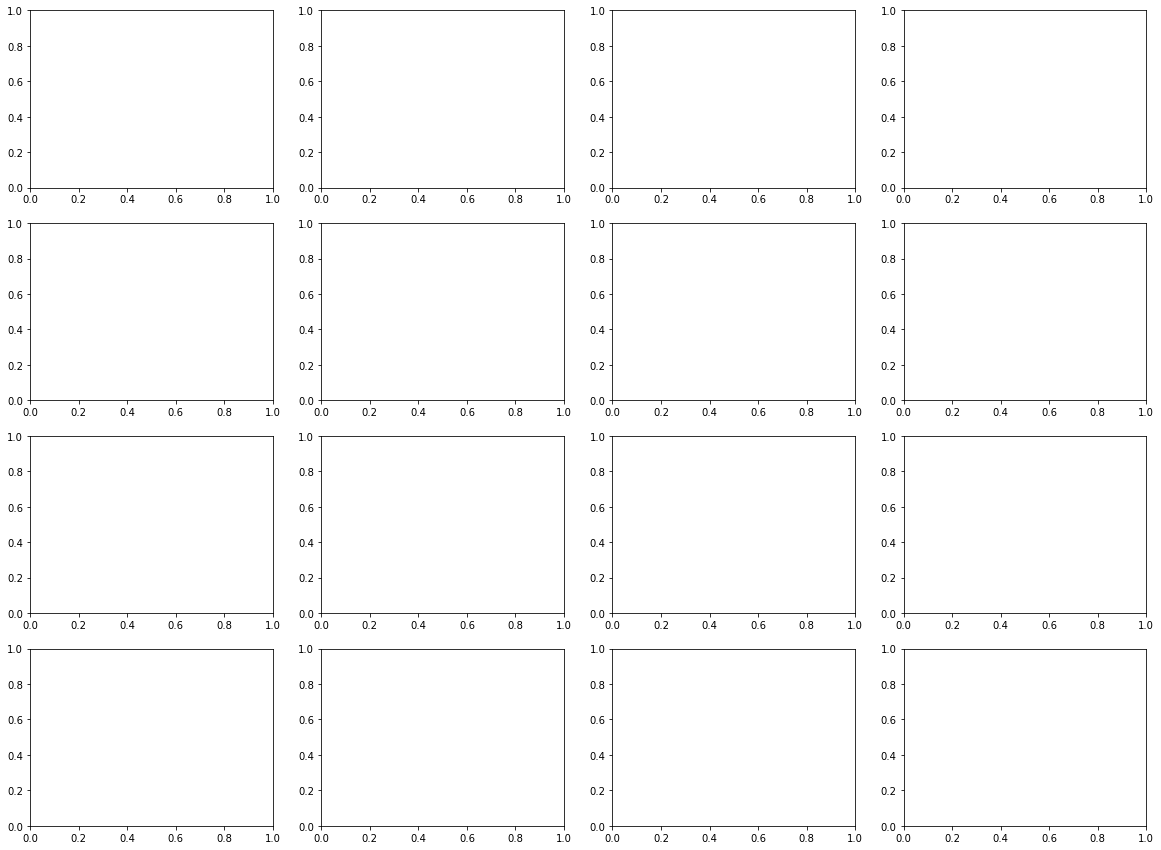

In [20]:
# histograms
fig, axs = plt.subplots(4, 4)
fig.set_figheight(15)
fig.set_figwidth(20)

#axs[0, 0].grid()
axs[0, 0].scatter(df['gs [kN/m3]'], df['qum [kPa]'], s = 10, c = 'orange')
axs[0, 0].set(ylabel = 'qum [kPa]')

#axs[0, 1].grid()
axs[0, 1].scatter(df['c [kPa]'], df['qum [kPa]'], s = 10, c = 'orange')

#axs[0, 2].grid()
axs[0, 2].scatter(df['phi [deg]'], df['qum [kPa]'], s = 10, c = 'orange')

#axs[0, 3].grid()
axs[0, 3].hist(df['qum [kPa]'])

#axs[1, 0].grid()
axs[1, 0].scatter(df['gs [kN/m3]'], df['phi [deg]'], s = 10, c = 'orange')
axs[1, 0].set(ylabel = '$\phi [deg]$')

#axs[1, 1].grid()
axs[1, 1].scatter(df['c [kPa]'], df['phi [deg]'], s = 10, c = 'orange')

#axs[1, 2].grid()
axs[1, 2].hist(df['phi [deg]'])

#axs[1, 3].grid()
axs[1, 3].scatter(df['qum [kPa]'], df['phi [deg]'], s = 10, c = 'orange')

#axs[2, 0].grid()
axs[2, 0].scatter(df['gs [kN/m3]'], df['c [kPa]'], s = 10, c = 'orange')
axs[2, 0].set(ylabel = 'c [kPa]')

#axs[2, 1].grid()
axs[2, 1].hist(df['c [kPa]'])

#axs[2, 2].grid()
axs[2, 2].scatter(df['phi [deg]'], df['c [kPa]'], s = 10, c = 'orange')

#axs[2, 3].grid()
axs[2, 3].scatter(df['qum [kPa]'], df['c [kPa]'], s = 10, c = 'orange')

#axs[3, 0].grid()
axs[3, 0].hist(df['gs [kN/m3]'])
axs[3, 0].set(xlabel = 'gs [kN/m3]', ylabel = 'gs [kN/m3]')

#axs[3, 1].grid()
axs[3, 1].scatter(df['c [kPa]'], df['gs [kN/m3]'], s = 10, c = 'orange')
axs[3, 1].set(xlabel = 'c [kPa]')

#axs[3, 2].grid()
axs[3, 2].scatter(df['phi [deg]'], df['gs [kN/m3]'], s = 10, c = 'orange')
axs[3, 2].set(xlabel = '$\phi [deg]$')

#axs[3, 3].grid()
axs[3, 3].scatter(df['qum [kPa]'], df['gs [kN/m3]'], s = 10, c = 'orange')
axs[3, 3].set(xlabel = 'qum [kPa]')

for ax in axs.flat:
    ax.label_outer()

plt.show()

In [ ]:
# histograms
fig, axs = plt.subplots(4, 4)
fig.set_figheight(15)
fig.set_figwidth(20)

#axs[0, 0].grid()
axs[0, 0].scatter(df['B (m)'], df['qum [kPa]'], s = 10, c = 'orange')
axs[0, 0].set(ylabel = 'qum [kPa]')

#axs[0, 1].grid()
axs[0, 1].scatter(df['L (m)'], df['qum [kPa]'], s = 10, c = 'orange')

#axs[0, 2].grid()
axs[0, 2].scatter(df['D (m)'], df['qum [kPa]'], s = 10, c = 'orange')

#axs[0, 3].grid()
axs[0, 3].hist(df['qum [kPa]'])

#axs[1, 0].grid()
axs[1, 0].scatter(df['B (m)'], df['D (m)'], s = 10, c = 'orange')
axs[1, 0].set(ylabel = 'D [m]')

#axs[1, 1].grid()
axs[1, 1].scatter(df['L (m)'], df['D (m)'], s = 10, c = 'orange')

#axs[1, 2].grid()
axs[1, 2].hist(df['D (m)'])

#axs[1, 3].grid()
axs[1, 3].scatter(df['qum [kPa]'], df['D (m)'], s = 10, c = 'orange')

#axs[2, 0].grid()
axs[2, 0].scatter(df['B (m)'], df['L (m)'], s = 10, c = 'orange')
axs[2, 0].set(ylabel = 'L [m]')

#axs[2, 1].grid()
axs[2, 1].hist(df['L (m)'])

#axs[2, 2].grid()
axs[2, 2].scatter(df['D (m)'], df['L (m)'], s = 10, c = 'orange')

#axs[2, 3].grid()
axs[2, 3].scatter(df['qum [kPa]'], df['L (m)'], s = 10, c = 'orange')

#axs[3, 0].grid()
axs[3, 0].hist(df['B (m)'])
axs[3, 0].set(xlabel = 'B [m]', ylabel = 'B [m]')

#axs[3, 1].grid()
axs[3, 1].scatter(df['L (m)'], df['B (m)'], s = 10, c = 'orange')
axs[3, 1].set(xlabel = 'L [m]')

#axs[3, 2].grid()
axs[3, 2].scatter(df['D (m)'], df['B (m)'], s = 10, c = 'orange')
axs[3, 2].set(xlabel = 'D [m]')

#axs[3, 3].grid()
axs[3, 3].scatter(df['qum [kPa]'], df['B (m)'], s = 10, c = 'orange')
axs[3, 3].set(xlabel = 'qum [kPa]')

for ax in axs.flat:
    ax.label_outer()

plt.show()

## BIAS de resistencia

In [ ]:
M = []
phi_lim = 36
COV = 0.5

df['phi caract'] = df['phi [deg]'] * (1 - 0.84 * COV)
df['phi'] = df.apply(lambda x: np.min([x['phi caract'], phi_lim]), axis=1)
df['gamma_g'] = df.apply(lambda x: gamma_g(x['B (m)'], x['D (m)'], x['NF [m]'], x['gs [kN/m3]']), axis=1)
df['gamma_q'] = df.apply(lambda x: gamma_q(x['D (m)'], x['NF [m]'], x['gs [kN/m3]']), axis=1)

In [21]:
df['qu_c [kPa]'] = df.apply(lambda x: Bearing_Capacity(x['gamma_g'], x['gamma_q'], x['phi'],
                                                        x['c [kPa]'], x['B (m)'], x['L (m)'],
                                                        x['D (m)'], 0, x['Shape'], 'hansen'), axis=1)
df['M'] = df['qum [kPa]'] / df['qu_c [kPa]']

NameError: name 'df' is not defined

In [22]:
M = df[(df['phi [deg]'] > 15) & (df['c [kPa]']<=20) & (df['B (m)']<=2) & (df['L (m)']<=2) & (df['D (m)']<=1)]['M'].to_numpy()
nf = np.size(M)
print('Cantidad de ensayos:', nf)

NameError: name 'df' is not defined

In [23]:
plt.hist(M, alpha = 1, density = True, bins = 60)
plt.xlim(0, 20)
plt.xlabel('Bias ($X_R$)')
plt.show();

NameError: name 'M' is not defined

In [24]:
#Ajuste de distribución

#Fit Distribución Lognormal
dist_LN = lognorm.fit(M)
x = np.linspace(0, 100, 100)
print(dist_LN)

#Fit Distribución beta
dist_beta = beta.fit(M)
x = np.linspace(0, 100, 100)
print(dist_beta)

#Ploteo
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 5))

#Ajuste Lognormal
ax1.hist(M, alpha = 0.3, density = True, bins=60)
param_LN = lognorm.pdf(x, dist_LN[0], dist_LN[1], dist_LN[2])
ax1.plot(x, param_LN, 'b--', lw = 3)
ax1.set_xlim(0, 30)
ax1.set_xlabel('Bias ($X_R$)')
ax1.set_title('Ajuste Lognormal (pdf) - Vesic (1975)')

#Ajuste beta
ax2.hist(M, alpha = 0.3, density = True, bins=60)
param_beta = beta.pdf(x, dist_beta[0], dist_beta[1], dist_beta[2], dist_beta[3])
ax2.plot(x, param_LN, 'b--', lw = 3)
ax2.set_xlim(0, 30)
ax2.set_xlabel('Bias ($X_R$)')
ax2.set_title('Ajuste beta (pdf) - Vesic (1975)')

plt.show()

NameError: name 'M' is not defined

NameError: name 'M' is not defined

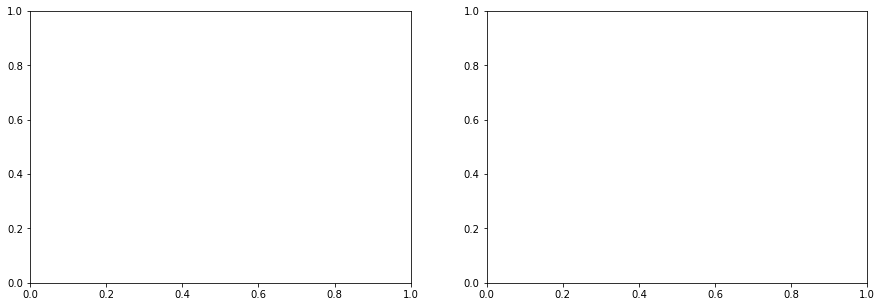

In [25]:
#Ploteo funciones acumuladas
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 5))

#Ajuste Lognormal
ax1.hist(M, bins = nf, alpha = 0.3, density = True, cumulative = 1)
param_LN = lognorm.cdf(x, dist_LN[0], dist_LN[1], dist_LN[2])
ax1.plot(x, param_LN, 'b--', lw = 3)
ax1.set_xlim(0, 30)
ax1.set_xlabel('Bias ($X_R$)')
ax1.set_title('Ajuste Lognormal (cdf) - Vesic (1975)')

#Ajuste beta
ax2.hist(M, bins = nf, alpha = 0.3, density = True, cumulative = 1)
param_beta = beta.cdf(x, dist_beta[0], dist_beta[1], dist_beta[2], dist_beta[3])
ax2.plot(x, param_beta, 'b--', lw = 3)
ax2.set_xlim(0, 30)
ax2.set_xlabel('Bias ($X_R$)')
ax2.set_title('Ajuste beta (cdf) - Vesic (1975)')

plt.show()

NameError: name 'M' is not defined

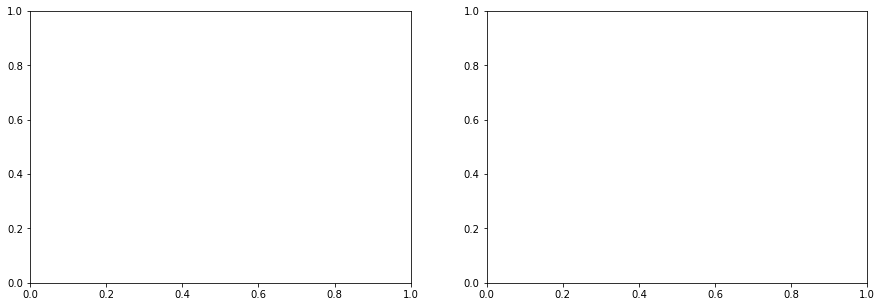

In [26]:
#Ploteo
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 5))

#Ajuste Lognormal
ax1.hist(M, alpha = 0.3, density = True, bins = 80)
param_LN = lognorm.pdf(x, dist_LN[0], dist_LN[1], dist_LN[2])
ax1.plot(x, param_LN, 'b--', lw = 3)
ax1.set_xlim(0, 20)
ax1.set_xlabel('Bias ($X_R$)')
ax1.set_title('Ajuste Lognormal (pdf) - Vesic (1975)')

#Ajuste Lognormal
ax2.hist(M, bins = nf, alpha = 0.3, density = True, cumulative = 1)
param_LN = lognorm.cdf(x, dist_LN[0], dist_LN[1], dist_LN[2])
ax2.plot(x, param_LN, 'b--', lw = 3)
ax2.set_xlim(0, 20)
ax2.set_xlabel('Bias ($X_R$)')
ax2.set_title('Ajuste Lognormal (cdf) - Vesic (1975)')

plt.show()

### Test de bondad de ajuste (Kolmogorov-Smirnov)

In [27]:
stat, p = kstest(M, 'lognorm', args = dist_LN)
print("KS Test - Lognorm distribution:")
print("stat    = %9.5f" % stat)
print("p-value = %9.5f" % p)

stat, p = kstest(M, 'beta', args = dist_beta)
print("KS Test - Beta distribution:")
print("stat    = %9.5f" % stat)
print("p-value = %9.5f" % p)

NameError: name 'M' is not defined

## Calibracion de RF

In [28]:
#Distribución probabilistica de los factores de carga

#Carga permanente
LF_D = 1.20
mu_bias_LF_D = 1.05
COV_bias_LF_D = 0.10
sigma_bias_LF_D = COV_bias_LF_D * mu_bias_LF_D

#Sobrecarga
LF_L = 1.60
mu_bias_LF_L = 1.00
COV_bias_LF_L = 0.25
sigma_bias_LF_L = COV_bias_LF_L * mu_bias_LF_L

kappa = 3.0 #Relación entre carga permanente y sobrecarga

In [29]:
#Seguridad probabilistica
PF_obj = 0.00135 #Equivalente a un beta = 3
Vp = 0.1 #Coeficiente de variación deseado del resultado de la simulación 
n = np.int(np.round((1 - PF_obj) / ((Vp ** 2) * PF_obj), decimals = 0)) #Cantidad de simulaciones Monte Carlo
n

<ipython-input-29-40138d4933c6>:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  n = np.int(np.round((1 - PF_obj) / ((Vp ** 2) * PF_obj), decimals = 0)) #Cantidad de simulaciones Monte Carlo


73974

In [30]:
#Funcion de falla
def g(phi, bias_RF, bias_LF_D, bias_LF_L, kappa):
    g = ((LF_D + LF_L * kappa) / phi) * bias_RF - (bias_LF_D + bias_LF_L * kappa)
    return g

In [31]:
tol = 0.1

PF = 1; RF = 0.0; d_RF = 0.01

while np.abs(1 - PF/PF_obj) > tol:
    RF = RF + d_RF

    if RF > 1:
        d_RF = d_RF / 2
        PF = 1
        RF = 0
    else:
        #bias_RF_rnd = stats.beta(dist_beta[0], dist_beta[1], loc = dist_beta[2], scale = dist_beta[3]).rvs(n)
        bias_RF_rnd = stats.lognorm(dist_LN[0], loc = dist_LN[1], scale = dist_LN[2]).rvs(n)
        bias_LF_D_rnd = np.random.normal(mu_bias_LF_D, sigma_bias_LF_D, n)
        bias_LF_L_rnd = np.random.gumbel(mu_bias_LF_L, sigma_bias_LF_L, n)
        gi = g(RF, bias_RF_rnd, bias_LF_D_rnd, bias_LF_L_rnd, kappa)
    
        cont = 0
        for i in range(n):
            if gi[i] < 0:
                cont = cont + 1
    
        PF = cont / n

#Ploteo de resultados
x_axis = np.arange(-4, 10, 0.01)
mean = np.mean(gi)
sd = np.std(gi)

#plt.plot(x_axis, norm.pdf(x_axis, mean, sd), 'r-', lw=5, alpha=0.8)
plt.hist(gi, bins = 1000, density=True, histtype='stepfilled', alpha=1)
plt.xlim(-10, 200)

plt.xlabel('$g(X_R, X_Q)$')

print('RF =', RF)

NameError: name 'dist_LN' is not defined